In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from commpy.filters import rrcosfilter

from ipywidgets import interact
import ipywidgets as widgets

 - This is a list
 - thjv

$$y[n]$$

In [9]:
class FIRfilter(object):
    def __init__(self, h, Ns):
        """
        create(initialize) a new FIR filter, return inital state
        h: filter taps
        Ns: Number of samples processed per block
        """

        M = 2**(math.ceil(np.log2(Ns+h)+1))

        buff = np.zeros(M)

        self.h = h
        self.Ns = Ns
        self.M = M
        self.buff = buff
        self.n_t = 0 #inital tail pointer
        self.n_p = 0 #???? temp pointer
    
    def fir(self, x):
        """
        Executes FIR block
        x : samples to process
        """
        y   = np.zeros(x.size)
        for i in range (x.size):
            self.buff[self.n_t] = x[i]
            self.n_t = (self.n_t + 1) % self.M
            self.ptr = (self.n_t-1) % self.M
            sum = 0.0

            for j in range((self.h).size):
                sum = sum + self.buff[self.ptr] * h[j]
                self.ptr = (self.ptr - 1) % self.M
            y[i] = sum
        return y

(array([ 9.5258644 , 15.86894586, 18.00120042, 21.38342062, 21.41963564,
        18.35361288, 20.87375693, 21.91326874, 18.28355835, 20.82771173,
        20.17377229, 20.72634805, 22.29408477, 23.6779061 , 25.53105334,
        23.11960565, 20.85773404, 21.12164837, 26.10191618, 21.92734042,
        16.3691847 , 18.91930551, 23.46425377, 25.41871692, 19.01727809,
        19.12998312, 22.83818786, 19.13906529, 20.66460947, 23.40883593,
        19.35453663, 22.12490133, 22.15334243, 18.66295426, 18.25280912,
        18.34427881, 20.70986793, 18.99568601, 21.41009951, 24.5621589 ,
        22.26590081, 20.86392972, 16.64574422, 15.94109026, 20.07042422,
        18.92371507, 17.6094836 , 20.7514886 , 21.58819676, 20.31389976,
        21.17329521, 19.395734  , 18.56823655, 20.50734034, 24.05377911,
        24.79060844, 22.60396007, 23.45770106, 24.54998243, 30.10719227,
        30.97453965, 26.60035689, 22.6060061 , 19.71276133, 22.44491589,
        28.59158131, 26.69953175, 30.46482578, 31.0

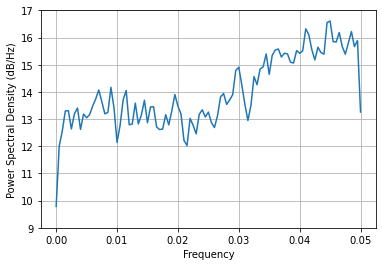

In [12]:
# Script to test the FIR filter.

# Global parameters
Nb = 100    # Number of buffers
Ns = 128	# Samples in each buffer

# Generate filter coefficients
beta = 0.5
fs = 0.1
root = 0	# 0=rc 1=root rc
M = 64

time_idx, h_rc = rrcosfilter(Ns , beta ,1/fs , fs)
#[h f H Hi] = win_method('rc_filt', p, 0.2, 1, M, 0);

# Generate some random samples.
x = np.random.randn(Ns*Nb)

# Type of simulation
stype = 0;	# Do simple convolution
#stype = 1;	% DSP-like filter

if stype==0:
    y = np.convolve(x, h_rc)
else:
    state_fir = FIRfilter(h_rc, Ns)
    xb = reshape(x, (Nb, Ns))
    yb = zeors(Nb, Ns)
    for j in range (Nb):
        y[j] = state_fir.fir(xb[j])

# Compute approximate transfer function using PSD
Npsd = 200	# Blocksize (# of freq) for PSD



plt.psd(y, Npsd, fs)
